In [1]:
import tensorflow as tf
from tensorflow import keras
import os

print(tf.__version__)

2.10.1


In [2]:
DATASET_NAME = 'BTDS_150MB_4C_5000'
DATASET_DIR = F'./Datasets/{DATASET_NAME}'
EPOCHS = 500
BATCH_SIZE = 32
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
COLOR_MODE = 'rgb'
IMAGE_CHANNELS = 3 if COLOR_MODE=='rgb' else 1
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
folders = len(next(os.walk(f"{DATASET_DIR}/train"))[1])
print(folders)
NUM_CLASSES = folders
PATIENCE = 100
AUTOTUNE = tf.data.AUTOTUNE

4


In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    F"{DATASET_DIR}/train/",
    color_mode = COLOR_MODE,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    batch_size = BATCH_SIZE,
)

val_ds = keras.utils.image_dataset_from_directory(
    F"{DATASET_DIR}/train/",
    color_mode = COLOR_MODE,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    batch_size = BATCH_SIZE,
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


['glioma', 'meningioma', 'notumor', 'pituitary']
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


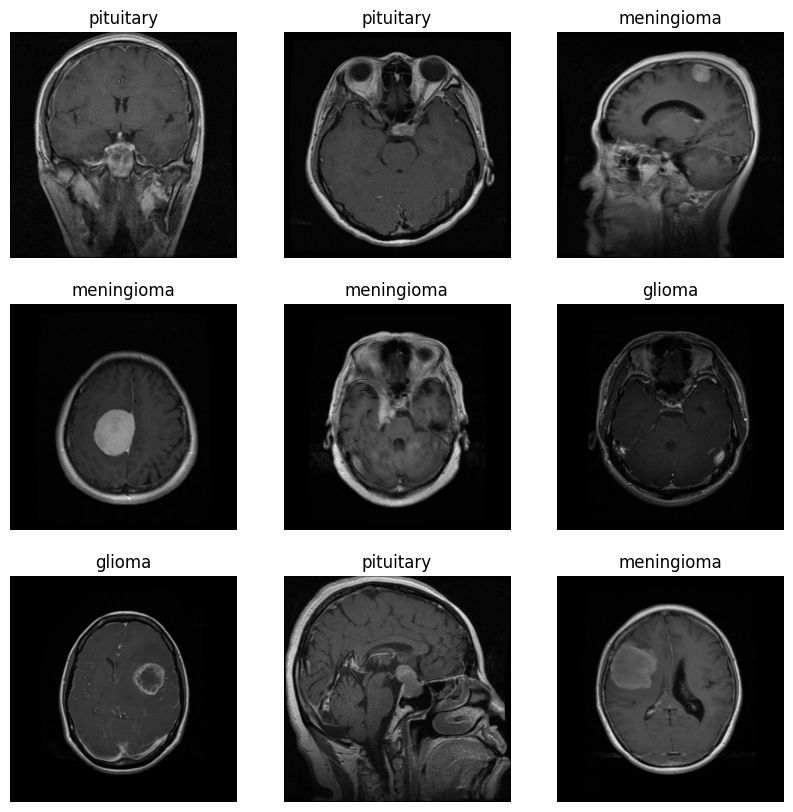

In [4]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
preprocessing = keras.Sequential([
    keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    keras.layers.Rescaling(1./255),
])

In [6]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(1),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
])

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
BN_MOMENTUM = 0.87

In [8]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)),

    preprocessing,

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    
    # keras.layers.BatchNormalization(momentum=0.87),

    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dropout(0.4),

    keras.layers.Dense(NUM_CLASSES, activation="softmax")
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing (Resizing)       (None, 64, 64, 3)         0         |
|                                                               |
| rescaling (Rescaling)     (None, 64, 64, 3)         0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                    

In [9]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_loss],
)

Epoch 1/500
143/143 [==============================] - 8s 40ms/step - loss: 0.6608 - sparse_categorical_accuracy: 0.7646 - val_loss: 5.1943 - val_sparse_categorical_accuracy: 0.2566
Epoch 2/500
143/143 [==============================] - 3s 24ms/step - loss: 0.3749 - sparse_categorical_accuracy: 0.8602 - val_loss: 7.0742 - val_sparse_categorical_accuracy: 0.3503
Epoch 3/500
143/143 [==============================] - 3s 23ms/step - loss: 0.2816 - sparse_categorical_accuracy: 0.9000 - val_loss: 5.2524 - val_sparse_categorical_accuracy: 0.5245
Epoch 4/500
143/143 [==============================] - 3s 23ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9271 - val_loss: 0.7424 - val_sparse_categorical_accuracy: 0.7373
Epoch 5/500
143/143 [==============================] - 3s 24ms/step - loss: 0.1414 - sparse_categorical_accuracy: 0.9497 - val_loss: 0.7052 - val_sparse_categorical_accuracy: 0.7557
Epoch 6/500
143/143 [==============================] - 3s 23ms/step - loss: 0.1140 - spars

Epochs run: 188


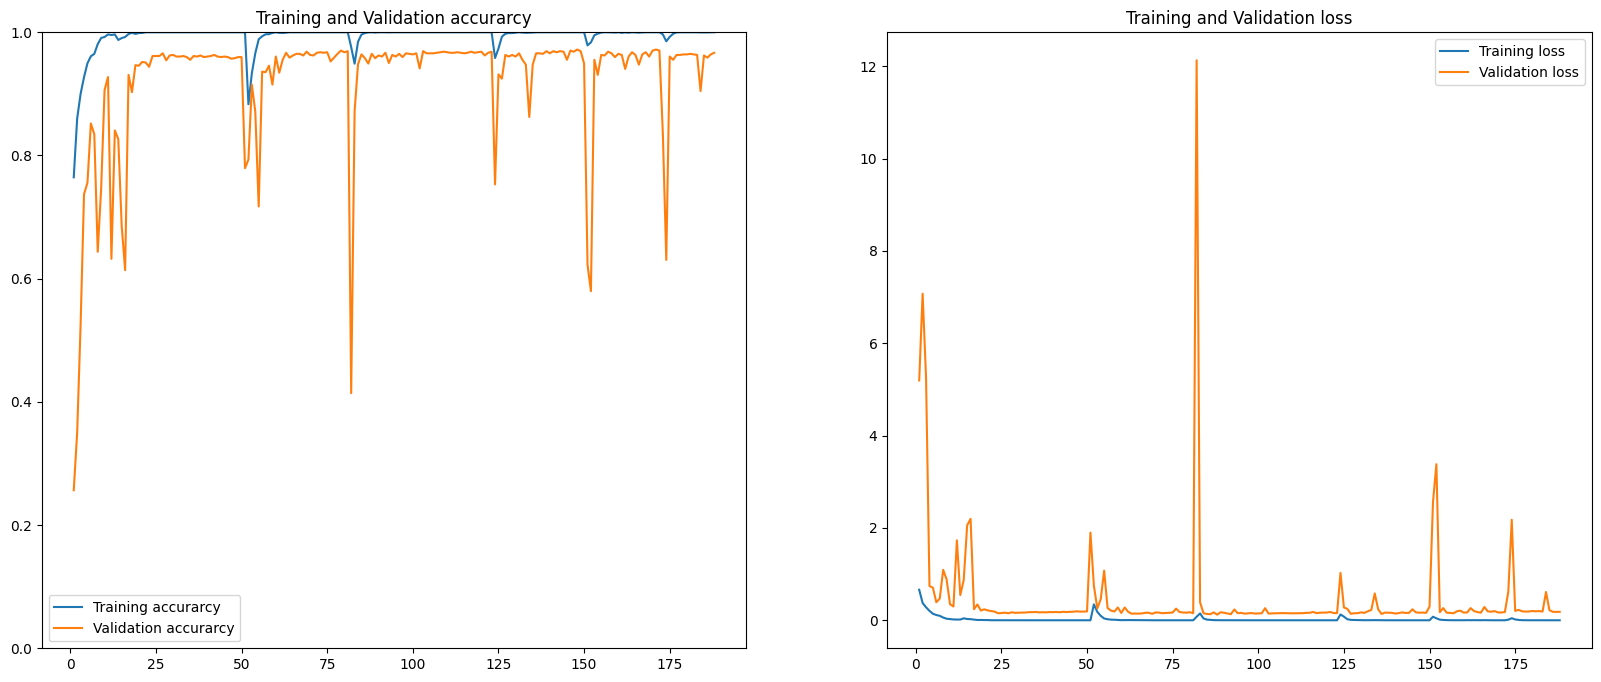

In [11]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [12]:
test_ds = keras.utils.image_dataset_from_directory(F"{DATASET_DIR}/test",color_mode=COLOR_MODE,)

results = model.evaluate(test_ds, verbose=0)

print("Test accuracy:", results[1]*100)
print("Test loss:", results[0]*100)

Found 1311 files belonging to 4 classes.
Test accuracy: 97.2540020942688
Test loss: 10.426223278045654


In [13]:
dot_img_file = '/tmp/model_architecture.png'
tf.keras.utils.plot_model(
    model,
    to_file=dot_img_file,
    show_shapes=True,
    show_layer_names=False,
    expand_nested=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
model.save(F'./SavedModels/{DATASET_NAME}')

INFO:tensorflow:Assets written to: ./SavedModels/BTDS_150MB_4C_5000\assets


INFO:tensorflow:Assets written to: ./SavedModels/BTDS_150MB_4C_5000\assets
